In [1]:
!python create_classifier_dataset.py

In [92]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [93]:
data = tf.keras.utils.image_dataset_from_directory("classifier_data") #, batch_size = 8, image_size = (128,128))

Found 25 files belonging to 4 classes.


In [94]:
CLASSES = ["copete", "cuerpo", "epigrafe", "titulo"]

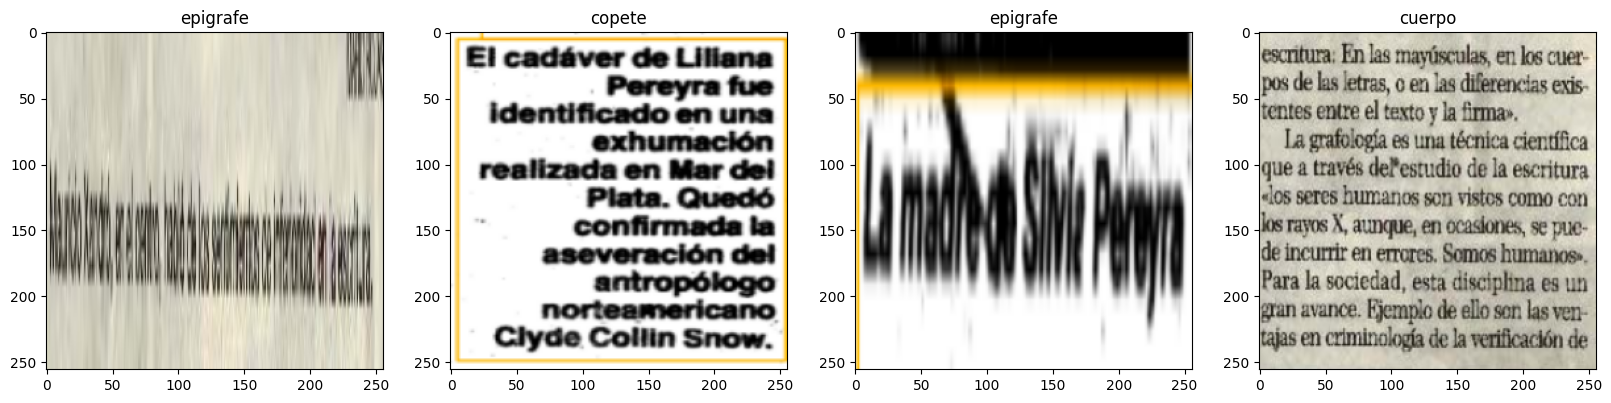

In [95]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    class_ = CLASSES[batch[1][idx]]
    ax[idx].title.set_text(class_)

## Preprocessing

### Scale Data

In [96]:
# Dividimos los valores para que esten entre 0 y 1
scaled_data = data.map(lambda x, y: (x/255, y))

In [97]:
scaled_data.as_numpy_iterator().next()[0].max()

1.0

### Split Data

In [98]:
# Cantidad de baches
len(scaled_data)

1

In [99]:
train_size = int(len(data)*0.7) + 1
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)

train_size + val_size + test_size

1

In [100]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Deep Model

### Build Model

In [203]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [204]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='sigmoid'))

In [205]:
# Por que la linea de arriba funciona y la de abajo rompe?

model.compile("adam", loss = SparseCategoricalCrossentropy() , metrics=["accuracy"])
# model.compile("adam", loss = tf.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [206]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 30, 30, 16)      

### Train

In [207]:
logdir = "logs"

In [208]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [209]:
hist = model.fit(train, epochs = 20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 40.6072 - accuracy: 0.6000
Epoch 2/20
1/1 [==============================] - 0s 73ms/step - loss: 1572.6307 - accuracy: 0.3200
Epoch 3/20
1/1 [==============================] - 0s 71ms/step - loss: 1205.1427 - accuracy: 0.1600
Epoch 4/20
1/1 [==============================] - 0s 71ms/step - loss: 332.4000 - accuracy: 0.2000
Epoch 5/20
1/1 [==============================] - 0s 69ms/step - loss: 159.0803 - accuracy: 0.0800
Epoch 6/20
1/1 [==============================] - 0s 69ms/step - loss: 58.9097 - accuracy: 0.6000
Epoch 7/20
1/1 [==============================] - 0s 68ms/step - loss: 44.8348 - accuracy: 0.6000
Epoch 8/20
1/1 [==============================] - 0s 67ms/step - loss: 12.8621 - accuracy: 0.4400
Epoch 9/20
1/1 [==============================] - 0s 67ms/step - loss: 41.4445 - accuracy: 0.2400
Epoch 10/20
1/1 [==============================] - 0s 66ms/step - loss: 1.9997 - accuracy: 0.7200
Epoch 11/20
1/1 

### Plot performance

KeyError: 'val_loss'

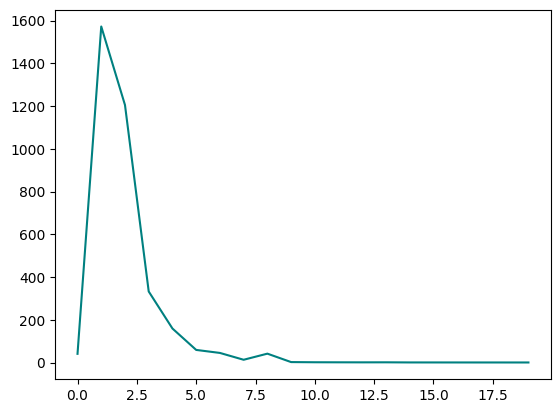

In [211]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

KeyError: 'val_accuracy'

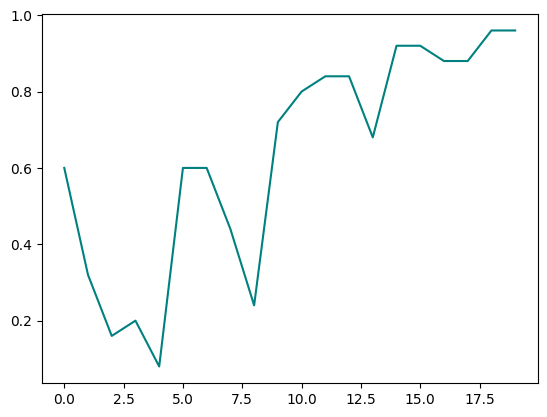

In [212]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluate

## Test

In [213]:
clase = "copete"
image_name = os.listdir(f"classifier_data/{clase}/")[0]
image_path = os.path.join(f"classifier_data/{clase}", image_name)
test_image = cv2.imread(image_path)

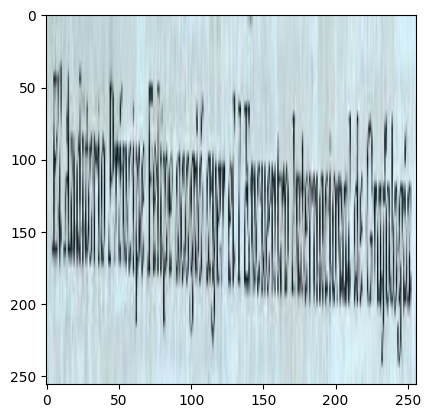

In [214]:
resize = tf.image.resize(test_image, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [215]:
yhat = model.predict(np.expand_dims(resize/255, 0))
prediction = CLASSES[np.argmax(yhat)]
print("La prediccion es", prediction)

1/1 [==============================] - 0s 53ms/step
La prediccion es copete


## Proximos pasos

- Labelear mas imagenes para tener mas data de entrenamiento
- Tener suficiente data como para armar un set de validacion
- Tunear el modelo
    - Elegir el input size
    - Elegir cantidad de capas
    - Entender las loss functions
- Aplicar data augmentation para tener mas imagenes de cada clase
    - Capaz podemos aumentar mas las imagenes de las clases mas escasas, como los epigrafes